
# Citizen Science
  Citizen science is the practice of public participation and collaboration in scientific research to increase scientific knowledge. Through citizen science, people share and contribute to data monitoring and collection programs.
<br>
One example for Citizen Science and the one we will look at is presented at Galaxy Zoo, where users can help researcher by marking galaxies and celestial objects in pictures.
<br>
<br>
# The Problem we face
  We are presented with data of user HIT's, a user HIT is a time-stamp that indicates when a user made a contribution to the project. A sequence of user HIT's is called a session if the HIT's are not separated by more than 30 minitues, our goal is to determine and perdict when a user will disengage for a given session.

In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [2]:
!wget ./data.csv https://github.com/amitsultan/CitizenScience/raw/main/data.csv

--2021-08-16 14:16:53--  http://./data.csv
Resolving . (.)... failed: No address associated with hostname.
wget: unable to resolve host address ‘.’
--2021-08-16 14:16:53--  https://github.com/amitsultan/CitizenScience/raw/main/data.csv
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/amitsultan/CitizenScience/main/data.csv [following]
--2021-08-16 14:16:53--  https://raw.githubusercontent.com/amitsultan/CitizenScience/main/data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4468925 (4.3M) [text/plain]
Saving to: ‘data.csv’

data.csv            100%[===================>]   4.26M  --.-KB/s    

# Data preparation
  The dataset is presented in the shape of a table with: User ID, Hit Date.
  <br>
  To use it as a dataset for a model we need to prepare the data and shape is as a valid training dataset, which will contain entries of features and labels.
  <br>
  We will group each user hits to one big list, we then go over each user list and create a set of features and labels for the given user based on the session length and disengange window.
  <br>
  <br>
  ***Data Normalization*** - After we transfer all dates to timesteps which shown as seconds, we need to normalize the data to give it a meaningful reference point. If not, the model will not be able to understand the connection between two unrelated entries or two related entries as there is no baseline to unite them.
  <br>
  To achive that we take each user entire HIT's list and normalize it a with MinMax method, this unbound users HIT's from one another and put the relative difference between HIT's at front.
  <br>
  <br>
  ***Creating the labels*** - For the labels we look at each user individually and analyze the HIT's, we take a window for size **n** and look at the next 5 mins to see if the user disengage from the session. The window is a sliding window so we only look at max of **n** HIT's at a time.
  <br>
  This can lead to problems as we limit ourself and our model with a static number, we might want to find another way to address this issue.
  <br>
  <br>
# Solution - LSTM
  We are given timestamps and asked to predict a future result, so the first approch to solve this kind of problems are Long Short-Term Memory (LSTM).
  <br>
  LSTM is an artificial recurrent neural network (RNN), and we use these kind of models to predict future results based on one or more fetures (timestamps).

In [3]:
header_list = ["user_id", "hit_date"]
df = pd.read_csv('/content/data.csv', names=header_list)
df['hit_date'] = pd.to_datetime(df['hit_date'])
df['hit_date'] = df['hit_date'].apply(lambda date: date.timestamp())
df

,user_id,hit_date
0,54999c8d9cd118282b001784,1.419354e+09
1,54999c91bb7b56040d0011e8,1.419354e+09
2,54999c8fbb7b565d7e000a7c,1.419354e+09
3,54999cb29cd1184d77000539,1.419354e+09
4,54068fab91ad6b597e000f97,1.419354e+09
...,...,...
99994,54a47e7a9cd1185134000c11,1.420479e+09
99995,54a47e7a9cd1185134000c11,1.420479e+09
99996,548a2a7627b562650b001344,1.420479e+09
99997,548a2a7627b562650b001344,1.420479e+09


In [4]:
grouped = df.groupby('user_id')['hit_date'].apply(list)
df1 = grouped.reset_index(name = 'total_hits')
df1

,user_id,total_hits
0,4d5835cc2a82e278e6000028,"[1420448863.0, 1420448871.0, 1420448881.0, 142..."
1,4fcaa6daae60e44a1900000b,"[1420083419.0, 1420083420.0, 1420083420.0, 142..."
2,50085cfc44dff81137000020,"[1419805955.0, 1420145743.0, 1420145749.0, 142..."
3,5013adf30454e27ae4000002,[1420236768.0]
4,503e2b5eba40af242e000052,"[1419599544.0, 1419711974.0, 1419873306.0, 141..."
...,...,...
938,54aaa28a9cd1187eeb0000cf,"[1420468897.0, 1420468904.0, 1420468925.0, 142..."
939,54aaa4f4bb7b565415000023,"[1420469582.0, 1420469614.0, 1420469626.0, 142..."
940,54aaa579bb7b563483000398,"[1420470080.0, 1420470568.0, 1420471461.0]"
941,54aaaba29cd1180cf7000070,"[1420471221.0, 1420471253.0, 1420471287.0, 142..."


In [5]:
def norm_timestamp(ts, min_v, max_v):
    return (ts - min_v) / (max_v - min_v)

In [6]:
def get_user_sessions(user_hits, delay = 30, save_as_timestamps=True):
    user_hits.sort()
    last_date = None
    all_sessions = []
    session = []
    for date in user_hits:
        if last_date == None:
            session.append(date)
        else:
            diff = date - last_date
            diff = diff / 60 # difference in mins
            if diff > 30: # new session
                all_sessions.append(session)
                session = [date]
            else:
                session.append(date)
        last_date = date
    if len(session) > 0:
        all_sessions.append(session)
    return all_sessions

In [7]:
df1['sessions'] = df1.apply(lambda row: get_user_sessions(row['total_hits']), axis = 1)
df1 = df1.drop(['total_hits'], axis = 1)
df1

,user_id,sessions
0,4d5835cc2a82e278e6000028,"[[1420448863.0, 1420448871.0, 1420448881.0, 14..."
1,4fcaa6daae60e44a1900000b,"[[1420083419.0, 1420083420.0, 1420083420.0, 14..."
2,50085cfc44dff81137000020,"[[1419805955.0], [1420145743.0, 1420145749.0, ..."
3,5013adf30454e27ae4000002,[[1420236768.0]]
4,503e2b5eba40af242e000052,"[[1419599544.0], [1419711974.0], [1419873306.0..."
...,...,...
938,54aaa28a9cd1187eeb0000cf,"[[1420468897.0, 1420468904.0, 1420468925.0, 14..."
939,54aaa4f4bb7b565415000023,"[[1420469582.0, 1420469614.0, 1420469626.0, 14..."
940,54aaa579bb7b563483000398,"[[1420470080.0, 1420470568.0, 1420471461.0]]"
941,54aaaba29cd1180cf7000070,"[[1420471221.0, 1420471253.0, 1420471287.0, 14..."


In [8]:
user_id_list = []
sessions_list = []
for index, row in df1.iterrows():
    user_id = row['user_id']
    last_session_end_time = None
    for session in row['sessions']:
        user_id_list.append(user_id)
        sessions_list.append(session)
sessioned_df = pd.DataFrame({'user_id': user_id_list, 'session': sessions_list})
sessioned_df

,user_id,session
0,4d5835cc2a82e278e6000028,"[1420448863.0, 1420448871.0, 1420448881.0, 142..."
1,4d5835cc2a82e278e6000028,"[1420470242.0, 1420470293.0, 1420470345.0, 142..."
2,4fcaa6daae60e44a1900000b,"[1420083419.0, 1420083420.0, 1420083420.0, 142..."
3,50085cfc44dff81137000020,[1419805955.0]
4,50085cfc44dff81137000020,"[1420145743.0, 1420145749.0, 1420145752.0, 142..."
...,...,...
2259,54aaa28a9cd1187eeb0000cf,"[1420468897.0, 1420468904.0, 1420468925.0, 142..."
2260,54aaa4f4bb7b565415000023,"[1420469582.0, 1420469614.0, 1420469626.0, 142..."
2261,54aaa579bb7b563483000398,"[1420470080.0, 1420470568.0, 1420471461.0]"
2262,54aaaba29cd1180cf7000070,"[1420471221.0, 1420471253.0, 1420471287.0, 142..."


In [9]:
for index, row in sessioned_df.iterrows():
    print(row['session'])
    break

[1420448863.0, 1420448871.0, 1420448881.0, 1420450388.0]


In [46]:
def disengage_by(hits, index, timer = 5):
    for i in range(index, len(hits) - 1):
        diff = (hits[i + 1] - hits[i]) / 60
        diff_from_start = (hits[i] - hits[index]) / 60 
        if diff_from_start >= 5:
            return False
        if diff >= 30:
            return True
    return True

def create_sets(hits, max_win_size = 50, norm = True):
    min_val = hits.min()
    max_val = hits.max()
    last_hit = hits[0] if not norm else norm_timestamp(hits[0], min_val, max_val)
    X, Y = [], []
    window_hits = [last_hit]
    for i in range(1, len(hits)):
        tmp = hits[i] if not norm else norm_timestamp(hits[i], min_val, max_val)
        X.append(window_hits[-max_win_size:])
        if disengage_by(hits, i):
            Y.append(1)
        else:
            Y.append(0)
        window_hits.append(tmp)
    return X, Y

In [47]:
X, Y = [], []
for name, group in df.groupby('user_id'):
    x, y = create_sets(group['hit_date'].values)
    X += x
    Y += y
X = np.array(X)
Y = np.array(Y)
print(X.shape)
print(Y.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


(99056,)
(99056,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [48]:
train_df = pd.DataFrame({'X': X, 'Y': Y})
train_df

,X,Y
0,[0.0],0
1,"[0.0, 0.0003295300078263377]",0
2,"[0.0, 0.0003295300078263377, 0.000741442517609...",1
3,"[0.0, 0.0003295300078263377, 0.000741442517609...",0
4,"[0.0, 0.0003295300078263377, 0.000741442517609...",0
...,...,...
99051,"[0.0, 0.1285140562248996, 0.26506024096385544,...",1
99052,[0.0],1
99053,"[0.0, 0.4]",1
99054,"[0.0, 0.4, 0.7846153846153846]",1


In [49]:
train_df['x_len'] = train_df['X'].apply(lambda r: len(r))
train_df

,X,Y,x_len
0,[0.0],0,1
1,"[0.0, 0.0003295300078263377]",0,2
2,"[0.0, 0.0003295300078263377, 0.000741442517609...",1,3
3,"[0.0, 0.0003295300078263377, 0.000741442517609...",0,4
4,"[0.0, 0.0003295300078263377, 0.000741442517609...",0,5
...,...,...,...
99051,"[0.0, 0.1285140562248996, 0.26506024096385544,...",1,15
99052,[0.0],1,1
99053,"[0.0, 0.4]",1,2
99054,"[0.0, 0.4, 0.7846153846153846]",1,3


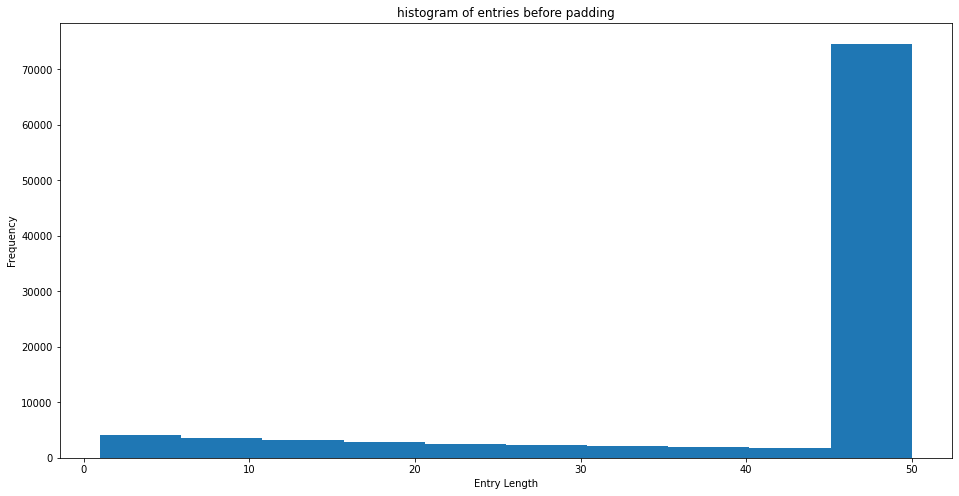

In [50]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.set_title('histogram of entries before padding')
ax.set_xlabel('Entry Length')
train_df['x_len'].plot.hist(ax=ax)

In [54]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

padded_X = pad_sequences(X, dtype='float32', value=0.0, padding='pre')
padded_X.shape

(99056, 50)

In [56]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Masking, Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


def fit_lstm(x, y, batch_size, nb_epoch, neurons, timesteps):
    X, Y = x, y
    features = 1
    reduce_lr = ReduceLROnPlateau(monitor='val_f1_m', factor=0.2,
                              patience=0, min_lr=0.0001, verbose = 2)
    early_stop = EarlyStopping(monitor='val_f1_m', verbose=2, patience=2, mode='auto')
    model = Sequential()
    model.add(Masking(mask_value=0., input_shape=(timesteps, features)))
    model.add(LSTM(neurons))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',f1_m,precision_m, recall_m])
    model.summary()
    model.fit(x, y, epochs = nb_epoch, verbose=2, validation_split = 0.2, batch_size=batch_size, callbacks=[reduce_lr, early_stop])
    return model

In [57]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(padded_X, Y, test_size=0.25)

In [58]:
model = fit_lstm(X_train, y_train, 128, 5, 64, padded_X.shape[1])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_3 (Masking)          (None, 50, 1)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                16896     
_________________________________________________________________
dense_9 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_10 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 17        
Total params: 19,521
Trainable params: 19,521
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
465/465 - 59s - loss: 0.6139 - accuracy: 0.6856 - f1_m: 0.1332 - precision_m: 0.3858 - recall_m: 0.0881 - 

In [60]:
model.evaluate(X_test, y_test)

774/774 [==============================] - 8s 11ms/step - loss: 0.5783 - accuracy: 0.7204 - f1_m: 0.3341 - precision_m: 0.7086 - recall_m: 0.2316


[0.5782768130302429,
 0.7204005718231201,
 0.33406099677085876,
 0.7085880637168884,
 0.2316257357597351]

In [59]:
preds = model.predict(X_test)

In [61]:
t = []
for i in range(len(preds)):
  if preds[i] >= 0.5:
    t.append(1)
  else:
    t.append(0)

Text(0.5, 1.0, 'Test result confusion matrix')

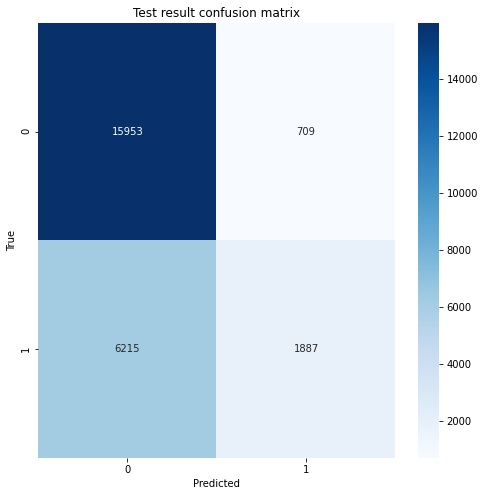

In [70]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

fig ,ax = plt.subplots(figsize=(8, 8))
cf_matrix = confusion_matrix(y_test, t)
sns.heatmap(cf_matrix, annot=True, fmt='g', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Test result confusion matrix')

In [ ]:
tmp1 = 0
tmp2 = 0
for tmp in Y:
  if tmp == 0:
    tmp1 += 1
  else:
    tmp2 += 1

In [ ]:
print(tmp1 /(tmp1 + tmp2))
print(tmp2 /(tmp1 + tmp2))

0.6754058310450655
0.3245941689549346


In [ ]:
model.pred(X[:10])